# A tutorial in torchAttacks (Adversarial attacks)
Here I have followed the following [example](https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118) for a convolution neural network.

However I followed this [tutorial](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html) for the adversarial attack stuff.

## Import.STONKS()

And also defining where to put the model weights

In [3]:
import torch
import torch.nn.functional as F
from torchattacks import *
from torchvision import transforms, models, datasets
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
from PIL import Image
from torch.autograd import Variable
from captum.attr import IntegratedGradients

train_again = False

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {DEVICE} device")

# Path to saving the attack
if train_again == True:
    save_akt_path = "../plotables/AttacksVGG.pth"
else:
    save_akt_path = "/Users/Alex/Documents/results/plotables/AttacksVGG.pth"
print(f"Saving model in path:{save_akt_path}")


Using cpu device
Saving model in path:/Users/Alex/Documents/results/plotables/AttacksVGG.pth


## Downloading data

Downloading photo from internet!

In [12]:
def download(url,fname):
    response = requests.get(url)
    with open(fname,"wb") as f:
        f.write(response.content)

# path for the downloaded images
imagePath = "../data/downloaded_pics/input.jpg"
imageDirectory = "../data/downloaded_pics/"

# Check whether the directory exists
if not os.path.exists(imageDirectory):
        os.mkdir(imageDirectory)
        print("A new directory 'downloaded_pics' was created under 'data'.")
else:
        print("Directory already exists.")
             
# Downloading the image    
download(
        "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02123394_Persian_cat.JPEG",
        imagePath)


# Opening the image
img = Image.open(imagePath) 

# defining labels for imagenet
labels_link = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"    
labels = requests.get(labels_link).json()

#labels = {int(idx):label for idx, label in labels_json}


Directory already exists.


Pre- and deprocessing of the image

In [13]:
def preprocess(image, size=224):
    transform = transforms.Compose([
        #transforms.Resize((size,size)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x[None]),
    ])
    return transform(image)

def deprocess(image):
    transform = transforms.Compose([
        transforms.Lambda(lambda x: x[0]),
        #transforms.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        #transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        transforms.ToPILImage(),
    ])
    return transform(image)

## Model under attack

The model obviously also needs to be defined:

In [14]:
#Using VGG-19 pretrained model for image classification
model = models.vgg19(pretrained=True).to(DEVICE)
#for param in model.parameters():
#    param.requires_grad = False

model.eval()
print()

Plot image

pixel values: min 0.0	max 1.0


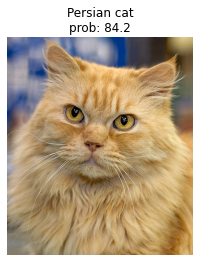

In [15]:
data = preprocess(img)
img_variable = Variable(data, requires_grad=True).to(DEVICE)

output = model(img_variable)
label_idx = torch.argmax(output).unsqueeze(0) #torch.max(output.data, 1)   #get an index(class number) of a largest element

x_pred = labels[label_idx.item()]

# Probability 
output_probs = F.softmax(output, dim=1)
x_pred_prob =  output_probs.max()*100


plt.axis('off')
plt.title(f"{x_pred}\nprob: {x_pred_prob:.1f}")
plt.imshow(np.asarray(img))

print(f"pixel values: min {img_variable.min().item()}\tmax {img_variable.max().item()}")


# different attacks on the model

In [19]:
atks = [
    #FGSM(model, eps=8/255),
    # BIM(model, eps=8/255, alpha=2/255, steps=100),
    # RFGSM(model, eps=8/255, alpha=2/255, steps=100),
    # CW(model, c=1, lr=0.01, steps=100, kappa=0),
    # PGD(model, eps=8/255, alpha=2/225, steps=100, random_start=True),
    # PGDL2(model, eps=1, alpha=0.2, steps=100),
    # EOTPGD(model, eps=8/255, alpha=2/255, steps=100, eot_iter=2),
    # FFGSM(model, eps=8/255, alpha=10/255),
    # TPGD(model, eps=8/255, alpha=2/255, steps=100),
    # MIFGSM(model, eps=8/255, alpha=2/255, steps=100, decay=0.1),
    VANILA(model),
    # GN(model, std=0.1),
    # APGD(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1, loss='ce'),
    # APGD(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1, loss='dlr'),
    # APGDT(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1),
    # FAB(model, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=False),
    # FAB(model, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=True),
    # Square(model, eps=8/255, n_queries=5000, n_restarts=1, loss='ce'),
    # AutoAttack(model, eps=8/255, n_classes=10, version='standard'),
    # OnePixel(model, pixels=5, inf_batch=50),
    # DeepFool(model, steps=100),
    # DIFGSM(model, eps=8/255, alpha=2/255, steps=100, diversity_prob=0.5, resize_rate=0.9)
]



def saliencyMapSingleImage(model, data):
    
    # Zero all existing gradient
    model.zero_grad()
    # Set requires_grad attribute of tensor. Important for Attack
    data.requires_grad_()
    
    # Get the index corresponding to the maximum score and the maximum score itself.
    scores = model(data)
    
    # Get the index corresponding to the maximum score and the maximum score itself.
    score_max_index = scores.argmax()
    score_max = scores[0,score_max_index]
   
    # Compute gradient of score_max with respect to the model
    score_max.backward()
    
    # flatten to one channel
    saliency_mean_abs = torch.mean(data.grad.abs(), dim=1) #torch.max(X.grad.data.abs(),dim=1)
    saliency_max_abs, _ = torch.max(data.grad.abs(), dim=1)

    return saliency_max_abs#, saliency_mean_abs

def intergratedGradSingleImage(model,data,label, trans: bool = False):
    ig = IntegratedGradients(model)
    model.zero_grad()
    attr_ig, delta = ig(ig, data, baselines=data * 0, return_convergence_delta=True)
    attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
    if trans:
        attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
    
    return attr_ig
 

def advAtkSingleImage(image,label, atk):
    # Attack and Saliency maps
    adv_image = atk(image, label)
    saliency_grad = saliencyMapSingleImage(model, image)
    saliency_intgrad = intergratedGradSingleImage(model)
    
    # Label and Probability 
    output_adv = model(adv_image)
    label_idx_adv = torch.argmax(output_adv).unsqueeze(0)
    x_pred_prob_adv = F.softmax(output_adv, dim=1).max()*100

    # Determind noise: avd = img + noise => noise = avd - img
    noise = adv_image - image
    
    # Save info in lists
    adv_dir =  [adv_image, noise, saliency_grad, saliency_intgrad] #['a','b']#[adv_image, noise]
    pred_dir = [label_idx_adv,x_pred_prob_adv] #{"label":label_idx_adv,"prob": x_pred_prob_adv}
    
    return adv_dir, pred_dir





Begin attacking!

In [23]:
if train_again == False:
    # Initialization
    adv_images = []
    pred_images = []
    adv_name = []

    for atk in atks:
        print("_"*70)
        print(atk)
        
        adv_im, adv_pred = advAtkSingleImage(img_variable, label_idx, atk)
        adv_images.append(adv_im)
        pred_images.append(adv_pred)
        adv_name.append(atk.__class__.__name__)

    # Compute Saliency map
    print("_"*70)
    print("\nsaliency map")
    saliency_im = saliencyMapSingleImage(model, img_variable)

    torch.save({"adv_name": adv_name, "adv_images" : adv_images, "pred_images" : pred_images}, save_akt_path)



______________________________________________________________________
VANILA(model_name=VGG, device=cpu, attack_mode=default, return_type=float)
______________________________________________________________________

saliency map


## Plotting 

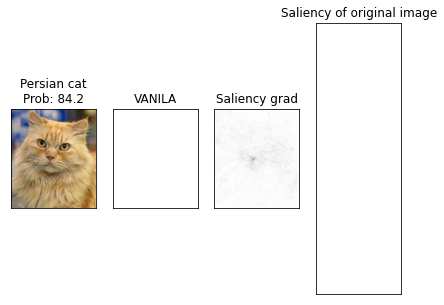

In [31]:

if train_again == False:
    # Loading!
    #attack = torch.load(save_akt_path,map_location = torch.device(DEVICE))
    #adv_images = attack["adv_images"]
    #pred_images = attack["pred_images"]
    #adv_name = attack["adv_names"]
    #saliency_im = attack["saliencyMap"]
    #saliency_im,_ = saliencyMapSingleImage(model, img_variable)

    #saliency_show = np.transpose(saliency_im,(1,2,0))
    cnt = 0

    fig1 = plt.figure(figsize=(7,5))
    fig1.patch.set_facecolor('white')

    for i in range(len(atks)):
        for j in range(len(adv_images[0])+1):
            cnt += 1

            plt.subplot(len(atks),len(adv_images[0]) + 1,cnt)
            plt.xticks([], [])
            plt.yticks([], [])
      
            
           
            if j == 0: # For adversarial example
                ex  = deprocess(adv_images[i][j])
                plt.title(f"{labels[pred_images[i][0].item()]}\nProb: {pred_images[i][1].item():.1f}")#title(pred_images[i][1].item())#
                plt.imshow(ex)
            elif j == 1: # For the noise 
                ex,_ = torch.max(adv_images[i][j][0], dim=0,  keepdim=True)
                ex = np.transpose(ex.detach(), (1,2,0))

                # standardize 
                ex = (ex - ex.min())/(ex.max() -ex.min())#adv_images[3][1][0].detach()
            
                plt.title(atks[i].__class__.__name__)
                plt.imshow(ex.max()-ex,cmap= 'gray')
            elif j == 2: # Saliency map
                ex = adv_images[i][j][0]
            

                # standardize 
                ex = (ex - ex.min())/(ex.max() -ex.min())
                plt.title('Saliency map')
                plt.imshow(ex.max() - ex, cmap='gray')
                

            else: # intergrated gradient
                
                ex,_ = torch.max(adv_images[i][j][0], dim=0,  keepdim=True)
                ex = np.transpose(ex.detach(), (1,2,0))

                # standardize 
                ex = (ex - ex.min())/(ex.max() -ex.min())#adv_images[3][1][0].detach()
            
                plt.title('Intergrated gradient')
                plt.imshow(ex.max()-ex,cmap= 'gray')
                #plt.imshow(saliency_show.max() - saliency_show, cmap = 'gray')


            
    #plt.tight_layout()
    plt.show()
    print()


### Plot histogram of noise

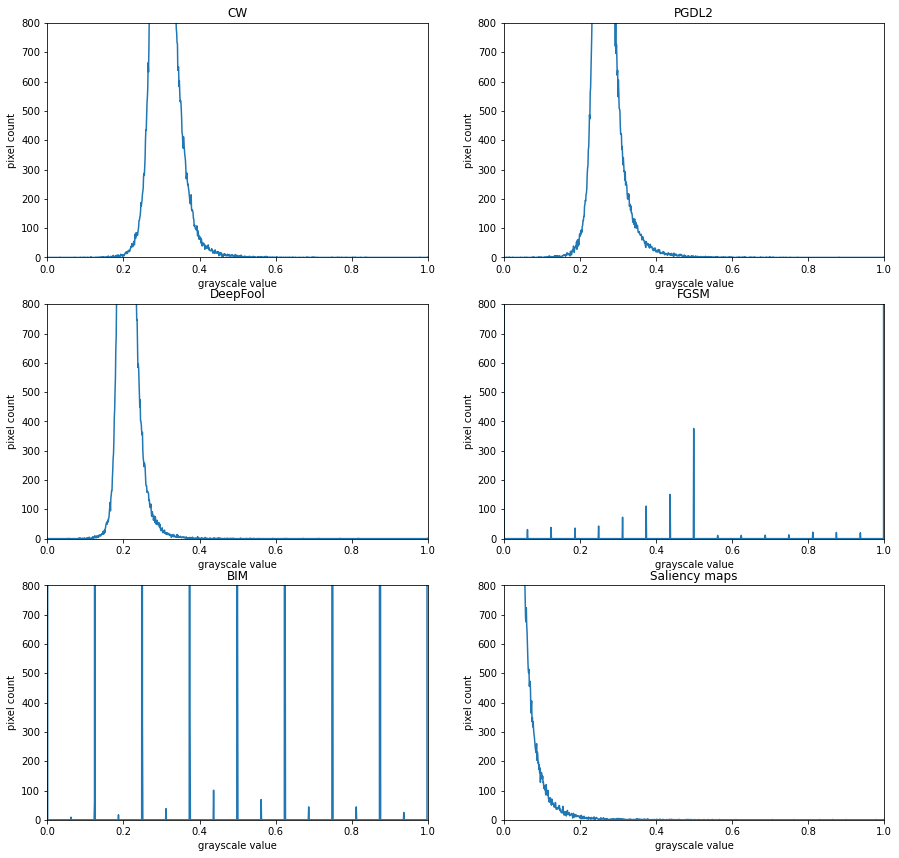

In [10]:
if train_again == False:
    
    atk_testidx = [3,5,20,0,1]

    fig2 = plt.figure(figsize=(15,25))
    fig2.patch.set_facecolor('white')
    x_range = [0, 1]
    y_range = [0,800]
    count = 0

    
    for i in atk_testidx:
        count +=1

        ex,_ = torch.max(adv_images[i][1][0], dim=0,  keepdim=True)
        ex = np.transpose(ex.detach(), (1,2,0))
        # standardize 
        ex = (ex - ex.min())/(ex.max() -ex.min())
        #print(ex.min(),ex.max())
    
        histogram, bin_edges = np.histogram(ex, bins=1000, range=(x_range[0], x_range[1]))
        plt.subplot(len(atk_testidx), 2,count)
        plt.title(atks[i].__class__.__name__)
        plt.xlabel("grayscale value")
        plt.ylabel("pixel count")
        plt.xlim(x_range)  # <- named arguments do not work here
        plt.ylim(y_range)

        plt.plot(bin_edges[0:-1], histogram) 

        
    ex = (saliency_im - saliency_im.min())/(saliency_im.max() -saliency_im.min())

    histogram, bin_edges = np.histogram(ex, bins=1000, range=(x_range[0], x_range[1]))

    plt.subplot(len(atk_testidx), 2,count +1)
    plt.title("Saliency maps")
    plt.xlabel("grayscale value")
    plt.ylabel("pixel count")
    plt.xlim(x_range)  # <- named arguments do not work here
    plt.ylim(y_range)
    plt.plot(bin_edges[0:-1], histogram)

    plt.show()


### Binaries interesting noise

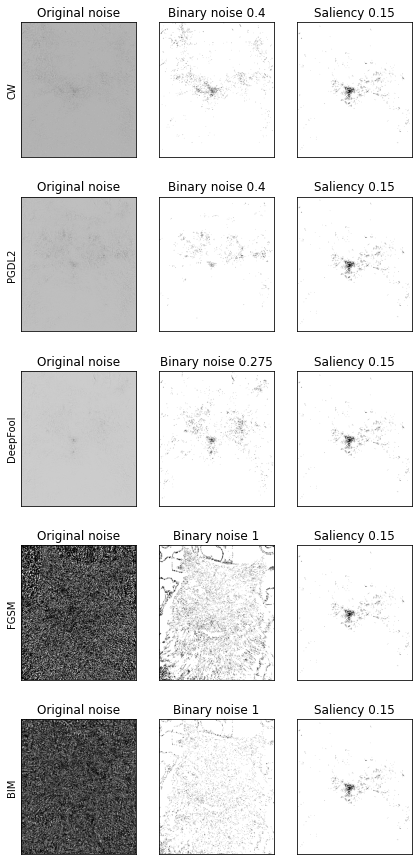

In [11]:
if train_again == False:
    def bin_image(image,threshold):
        return (image<threshold).int()

    cnt = 0
    count = 0
    threshold = [0.4,0.4,0.275,1,1] # idx: [3,5,20,0,1]
    thresholdS = 0.15

    fig1 = plt.figure(figsize=(7,70))
    fig1.patch.set_facecolor('white')

    for i in atk_testidx:
        for j in range(len(adv_images[0])+1):
            cnt += 1

            plt.subplot(len(atks),len(adv_images[0]) + 1,cnt)
            plt.xticks([], [])
            plt.yticks([], [])
      
            
           
            if j == 0: # Noise
                ex,_ = torch.max(adv_images[i][j+1][0], dim=0,  keepdim=True)
                ex = np.transpose(ex.detach(), (1,2,0))

                # standardize 
                ex = (ex - ex.min())/(ex.max() -ex.min())#adv_images[3][1][0].detach()
            
                plt.title("Original noise")
                plt.ylabel(atks[i].__class__.__name__)
                plt.imshow(ex.max()-ex,cmap= 'gray')
            elif j == 1: # Bin noise
                ex,_ = torch.max(adv_images[i][j][0], dim=0,  keepdim=True)
                ex = np.transpose(ex.detach(), (1,2,0))

                # standardize 
                ex = (ex - ex.min())/(ex.max() -ex.min())#adv_images[3][1][0].detach()
                ex_bin = bin_image(ex,threshold[count])
                plt.title(f"Binary noise {threshold[count]}")
                plt.imshow(ex_bin,cmap= 'gray')

                count += 1

            else: # Saliency map!
                plt.title(f'Saliency {thresholdS}')

                ex,_ = torch.max(saliency_im, dim=0,  keepdim=True)
                ex = np.transpose(ex.detach(), (1,2,0))

                # standardize 
                ex = (ex - ex.min())/(ex.max() -ex.min())
                ex_bin = bin_image(ex,thresholdS)
                plt.imshow(ex_bin, cmap = 'gray')


            
    #plt.tight_layout()
    plt.show()
    print() # make saliency map of attacked image, more examples, more saliency maps? kig på TPDG

## Sanity check: noise correctly?

In [12]:
if train_again == False:
    for i in range(18):
        # noise [i][1]
        noise_test = adv_images[i][1][0]
        # attacked img [i][0]
        adv_test = adv_images[i][0][0]

        
        #print(noise_test.size(),adv_test.size(),img_variable[0].size())
        
        img_noise = img_variable[0] + noise_test

        test0 = img_noise - adv_test

        print(atks[i].__class__.__name__, test0.min().item(),test0.max().item())
    






FGSM 0.0 0.0
BIM -3.725290298461914e-09 9.313225746154785e-10
RFGSM 0.0 0.0
CW 0.0 0.0
PGD 0.0 0.0
PGDL2 0.0 0.0
EOTPGD 0.0 0.0
FFGSM 0.0 0.0
TPGD 0.0 0.0
MIFGSM 0.0 0.0
VANILA 0.0 0.0
GN 0.0 0.0
APGD -1.862645149230957e-09 9.313225746154785e-10
APGD 0.0 0.0
APGDT -3.725290298461914e-09 9.313225746154785e-10
FAB 0.0 0.0
FAB 0.0 0.0
Square 0.0 0.0


Convert to py file

In [13]:
!jupyter nbconvert --to script torchattacks_IMAGENET.ipynb

[NbConvertApp] Converting notebook torchattacks_IMAGENET.ipynb to script
[NbConvertApp] Writing 13006 bytes to torchattacks_IMAGENET.py
